In [191]:
import collections
import heapq
import matplotlib.pyplot as plt
import numpy as np
import os, time, json

import itertools, sys, math, time
from scipy.spatial import distance as dist
from numpy import linalg

from matplotlib import offsetbox
from scipy.sparse import csr_matrix
from sklearn import cluster, datasets, decomposition, ensemble, lda, manifold, random_projection
from sklearn.decomposition import TruncatedSVD

from sklearn import svm, grid_search
from sklearn.decomposition import PCA, SparsePCA
from scipy import sparse as sp

from sklearn import cluster

%matplotlib inline

In [2]:
def sparse_where(sparse_matrix, num):
    """
    np.where() for a sparse matrix. Returns a set of indices.
    """
    return set(np.where(sparse_matrix[num,:].toarray())[1].tolist())

def sparse_vals(row):
    return row[np.where(row.toarray())[0]]


In [3]:
# Skip parts that take a long time.
SKIP_LONG_PARTS = True

# Create a dense representation of the data.
CREATE_DENSE_ARRAY = False

NUM_SPEECHES = 2740

NUM_DEBATES = 38

In [4]:
WORD_INDEX = 0
WORD_FREQ = 1

# Used for building the sparse data matrix.
sparse_indptr = [0]
sparse_indices = []
sparse_data = []
vocabulary = {}

inverted_index = collections.defaultdict(set)

dense_data = None

print 'Reading data.'
for line_num, line in enumerate(open('speech_vectors.csv')):
    new_row = [(idx,float(freq)) for idx, freq in enumerate(line.strip().split(',')) if float(freq) > 0.0]
    for i,f in new_row:
        sparse_indices.append(i)
        sparse_data.append(f)
        inverted_index[i].add(line_num)
    sparse_indptr.append(len(sparse_indices))
    
    if line_num % 500 == 0:
        print 100.0 * line_num / 2740, '%'
print 100.0 * line_num / 2740, '%'

sparse_data = csr_matrix((sparse_data, sparse_indices, sparse_indptr), dtype=float)
print 'Done reading data.'

print sparse_data.shape

Reading data.
0.0 %
18.2481751825 %
36.496350365 %
54.7445255474 %
72.9927007299 %
91.2408759124 %
99.9635036496 %
Done reading data.
(2740, 50000)


In [5]:
speech_graph = []
for line in open('speech_graph.csv'):
    speech_graph.append( [float(i) for i in line.strip().split(',')] )
    
print len(speech_graph)
sparse_speech_graph = csr_matrix(speech_graph)


2740


##Random Projection

In [61]:
# run PCA on data
# truncated_svd = TruncatedSVD(n_components=20)
# feature_vectors = truncated_svd.fit_transform(sparse_data[:, :25000])

feature_vectors = sparse_data[:, 25000:].toarray()

# Sparse random project to reduce dimensionality

# transformer = random_projection.SparseRandomProjection(n_components=200)
# transformer = random_projection.GaussianRandomProjection(n_components=1000)

# feature_vectors = transformer.fit_transform(sparse_data[:, :25000])
# print feature_vectors.shape

sims = np.zeros((2740, 2740))
print 'done'

done


## Cosine Sim Matrix

In [67]:
def cosine_sim_sparse(s1, s2):
#     print 'norm1' + str(linalg.norm(s1.toarray())) + ' norm2: ' + str(linalg.norm(s2.toarray()))
#     print 'norms ' + str(math.sqrt(s1.dot(s1.T).sum()) * math.sqrt(s2.dot(s2.T).sum()))
#     print 's1 ' + str(set(s1.indices).inter/section(set(s2.indices)))
#     print s1.dot(s2.T)/(math.sqrt(s1.dot(s1.T).sum()) * math.sqrt(s2.dot(s2.T).sum()))
    dot = s1.dot(s2.T)
    norm = (math.sqrt(s1.dot(s1.T).sum()) * math.sqrt(s2.dot(s2.T).sum()))
    if norm == 0:
        return 0
    return (dot/norm)

start = time.time()
for i in range(0, 2740):
    s1 = feature_vectors[i]
    if i % 10 == 0:
        sys.stdout.write('\r')
        sys.stdout.write("%d" % (i))
        sys.stdout.flush()
    
    for j in range(i, 2740):
        s2 = feature_vectors[j]
        sim = cosine_sim_sparse(s1, s2)
#         if j % 200 == 0:
#             sys.stdout.write('\r')
#             sys.stdout.write("%d %d %s " % (i, j, ' time left: ' + str(1.5*(37538-(i+1)*j/200)/60 )))
#             sys.stdout.write("sim: %s" % sim )
#             sys.stdout.flush()
        sims[i][j] = sim
        sims[j][i] = sim

# np.savetxt('files/sims_matrix.txt', sims)
all_sims = sims.flatten()
print '# sims: ' + str(len(all_sims))
plt.hist(all_sims, bins=25)

print 'done'

2730[[ 1.          0.57268869  0.30141198 ...,  0.52461816  0.46559629
   0.31026729]
 [ 0.57268869  1.          0.31102184 ...,  0.55991941  0.45131427
   0.31791433]
 [ 0.30141198  0.31102184  1.         ...,  0.24528366  0.30099105
   0.45037735]
 ..., 
 [ 0.52461816  0.55991941  0.24528366 ...,  1.          0.52608767
   0.24331412]
 [ 0.46559629  0.45131427  0.30099105 ...,  0.52608767  1.          0.33531054]
 [ 0.31026729  0.31791433  0.45037735 ...,  0.24331412  0.33531054  1.        ]]
done


## TF-IDF and Stopping

In [186]:
avg_word_freqs = {}
for row in range(2740):
    sys.stdout.write('\rrow %d' % row)
    sys.stdout.flush()
    for word, freq in enumerate(sparse_data[row].toarray()[0]):
        if freq == 0: continue
        if word not in avg_word_freqs:
            avg_word_freqs[word] = 0
        avg_word_freqs[word] += freq

for word in avg_word_freqs.keys():
    avg_word_freqs[word] /= 2740.0


row 2739

(array([49619,   211,    35,    37,    11,     7,    10,    14,     4,
            0,    11,     3,     0,     0,     3,     5,     1,     2,
            5,     0,     5,     0,     0,     2,     2,     0,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     2,     1,     3,     3,
            0,     1,     0,     1,     1]),
 array([ 0.        ,  0.00032268,  0.00064536,  0.00096804,  0.00129072,
         0.0016134 ,  0.00193608,  0.00225876,  0.00258144,  0.00290412,
         0.0032268 ,  0.00354949,  0.00387217,  0.00419485,  0.00451753,
         0.00484021,  0.00516289,  0.00548557,  0.00580825,  0.00613093,
         0.00645361,  0.00677629,  0.00709897,  0.00742165,  0.00774433,
         0.00806701,  0.00838969,  0.00871237,  0.00903505,  0.00935773,
         0.00968041,  0.01000309,  0.01032578,  0.01064846,  0.01097114,
         0.01129382,  0.0116165 ,  0.01193918,  0.01226186,  0.01258454,
         0.01290

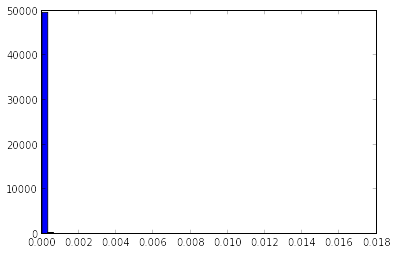

In [185]:
plt.hist(avg_word_freqs.values(), bins=50)

##Create SVM training set

37# similar speeches: 29136
# labels: 2114


(array([ 22,  20,   3,  46,   3,   1,  61,  18,  48, 125,  21,   7,   1,
          6,  14, 174, 112,   1, 546,  62,  49,  21,  18,   1,   3, 211,
         23,   2,   1,  10, 350,  50,   9,   5,  11,   8,  21,  30]),
 array([  0.        ,   0.97368421,   1.94736842,   2.92105263,
          3.89473684,   4.86842105,   5.84210526,   6.81578947,
          7.78947368,   8.76315789,   9.73684211,  10.71052632,
         11.68421053,  12.65789474,  13.63157895,  14.60526316,
         15.57894737,  16.55263158,  17.52631579,  18.5       ,
         19.47368421,  20.44736842,  21.42105263,  22.39473684,
         23.36842105,  24.34210526,  25.31578947,  26.28947368,
         27.26315789,  28.23684211,  29.21052632,  30.18421053,
         31.15789474,  32.13157895,  33.10526316,  34.07894737,
         35.05263158,  36.02631579,  37.        ]),
 <a list of 38 Patch objects>)

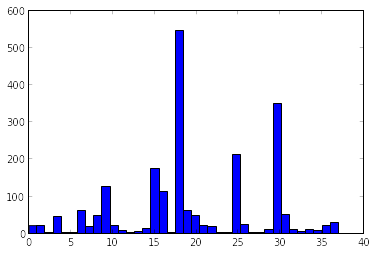

In [164]:
original_cluster_labels = []
cluster_labels = {}

# populate cluster labels with initial given
with open('files/hint.csv', 'r') as labels_file:
    for line in labels_file:
        vals = line.split(',')
        row = int(vals[0])
        label = int(vals[1].strip())
        original_cluster_labels.append( (row, label) )
        cluster_labels[row] = (label, 1)

# propogate labels with similar rows based on cosine similarity
sim_count = 0
for row, label in original_cluster_labels:
#     row_sims = sorted(sims[row], reverse=True)
    sys.stdout.write('\r%d' % label)
    sys.stdout.flush()
    for i, sim in enumerate(sims[row]):
        if i == row: continue
        if sim > 0.6:
            sim_count += 1
            if i not in cluster_labels:
                cluster_labels[i] = (label, sim)
            else:
                _, old_sim = cluster_labels[i]
                if sim > old_sim:
                    cluster_labels[i] = (label, sim)

print '# similar speeches: ' + str(sim_count)
print '# labels: ' + str(len(cluster_labels))
# print zip(*cluster_labels)[1]
label_freqs = list(zip(*cluster_labels.values())[0])
label_freqs.sort()

# print label_freqs
# print [(key, len(list(group))) for key, group in itertools.groupby(label_freqs)]

plt.hist(label_freqs, bins=38)


In [144]:
# plt.hist(sims[5], bins=25)

## SVM Multiclass

In [165]:
# construct SVM training input
X = []
Y = []
for row, (label, sim) in cluster_labels.iteritems():
    X += [feature_vectors[row]]
    Y += [label]
X = np.array(X)
Y = np.array(Y)
print X.shape, Y.shape
# plt.hist(Y, bins=25)

# train SVM, searching over paramaters
parameters = {'kernel':('linear', 'rbf'), 'C':np.arange(1, 10, 0.5)}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)

lin_clf = svm.LinearSVC()
print lin_clf.fit(X, Y)

(2114, 25000) (2114,)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)


[18 18  6 ..., 18 18 32]


(array([  44,    0,  135,    0,    0,    0,    0,    0,    0,  202,    0,
        1961,    3,    0,   17,    0,   84,   13,    0,    0,  254,    7,
           0,    0,   20]),
 array([  3.  ,   4.32,   5.64,   6.96,   8.28,   9.6 ,  10.92,  12.24,
         13.56,  14.88,  16.2 ,  17.52,  18.84,  20.16,  21.48,  22.8 ,
         24.12,  25.44,  26.76,  28.08,  29.4 ,  30.72,  32.04,  33.36,
         34.68,  36.  ]),
 <a list of 25 Patch objects>)

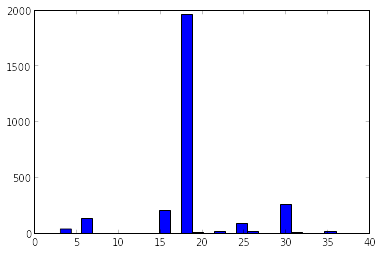

In [166]:
predictions = lin_clf.predict(feature_vectors)
print predictions
plt.hist(predictions, bins=25)

In [195]:
rows_over_365 = np.array(json.loads(open('files/rows_over_365.json', 'r').read()))
print 'done'

done


(922, 922)


(array([283,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 296,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 343]),
 array([ 0.        ,  0.05263158,  0.10526316,  0.15789474,  0.21052632,
         0.26315789,  0.31578947,  0.36842105,  0.42105263,  0.47368421,
         0.52631579,  0.57894737,  0.63157895,  0.68421053,  0.73684211,
         0.78947368,  0.84210526,  0.89473684,  0.94736842,  1.        ,
         1.05263158,  1.10526316,  1.15789474,  1.21052632,  1.26315789,
         1.31578947,  1.36842105,  1.42105263,  1.47368421,  1.52631579,
         1.57894737,  1.63157895,  1.68421053,  1.73684211,  1.78947368,
         1.84210526,  1.89473684,  1.94736842,  2.        ]),
 <a list of 38 Patch objects>)

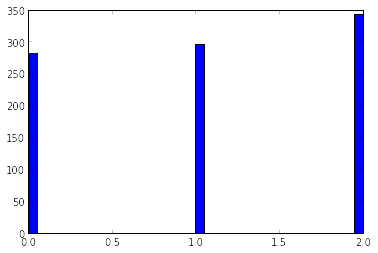

In [207]:
# spectral = SpectralClustering(n_clusters=4)

vectors_big_clusters = np.array(speech_graph)[rows_over_365]
vectors_big_clusters = vectors_big_clusters[:, rows_over_365]

print vectors_big_clusters.shape
spectral_labels = cluster.spectral_clustering(vectors_big_clusters, n_clusters=3)
plt.hist(spectral_labels, bins=38)